In [2]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

In [3]:
df = pd.read_csv('../data/creditcard.csv')

# standard scale Amount
ss = StandardScaler()
df['normAmount'] = ss.fit_transform(pd.DataFrame(df['Amount']))

# drop Time and Amount
df.drop(columns = ['Time','Amount'], inplace = True)

X = df.drop(columns = 'Class')
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

# create SMOTE
sm = SMOTE(random_state = 42)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train.ravel())


In [4]:
# datset with stratify
X_train_sf, X_test_sf, y_train_sf, y_test_sf = train_test_split(X, y, stratify = y, random_state = 42)


X_train_sm_sf, y_train_sm_sf = sm.fit_sample(X_train_sf, y_train_sf.ravel())

In [5]:
def plot_confusion_matrix(cm,title):
    plt.figure(figsize = (8,8))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.xticks(ticks = [0,1],
               labels = ['predict normal','predict fraud'], 
               size = 12)
    plt.yticks(ticks = [0,1],
               labels = ['actual normal','actual fraud'], 
               size = 12)

    # cm.max() shows the larger value for class 0 and 1
    thresh = cm.max() / 2.
    
    # cm.shape = (2,2), i,j shows (0,0,1,1), (1,0,1,0)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # cm[i,j] only works with confusion_matrix without pd.DataFrame, it shows each data in matrix
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size =20)
    plt.xlabel('Predicted label', size = 20)
    plt.title(title, size = 30)

In [6]:
def feature_importance(model,df = X_train_sm):
    predictors = [x for x in df.columns]
    importance = [x for x in model.coef_[0]]
    feat_imp = pd.Series(importance,predictors).sort_values(ascending = False)
    
    plt.figure(figsize = (8,6))
    feat_imp.plot(kind = 'bar')
    plt.ylabel('Coef')
    plt.title('Feature Coef', size = 20);

In [7]:
def model_vis(model, index):
    prediction_train = model.predict(X_train)
    prediction_test = model.predict(X_test)
    
    cnf_train = confusion_matrix(y_train, prediction_train)
    cnf_test = confusion_matrix(y_test, prediction_test)
    
    recall_train = cnf_train[1,1] / (cnf_train[1,1] + cnf_train[1,0])
    recall_test = cnf_test[1,1] / (cnf_test[1,1] + cnf_test[1,0])
    
    precision_train = cnf_train[1,1] / (cnf_train[1,1] + cnf_train[0,1])
    precision_test = cnf_test[1,1] / (cnf_test[1,1] + cnf_test[0,1])
    
    roc_train = roc_auc_score(y_train, prediction_train)
    roc_test = roc_auc_score(y_test, prediction_test)

    result = {
        'false_positive_test' : cnf_test[0,1],
        'false_negative_test' : cnf_test[1,0],
        'recall_train' : recall_train, 
        'recall_test' : recall_test,
        'precision_train' : precision_train, 
        'precision_test' : precision_test,
        'roc_train' : roc_train,
        'roc_test' : roc_test,
    }
    
    output = pd.DataFrame(result,index = [index])
    
    plot_train = plot_confusion_matrix(cnf_train,f'{index} train')
    plot_test = plot_confusion_matrix(cnf_test,f'{index} test')
    
    
    return output

# Baseline

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
default,1225,11,0.978892,0.902655,0.093853,0.076865,0.981046,0.942711


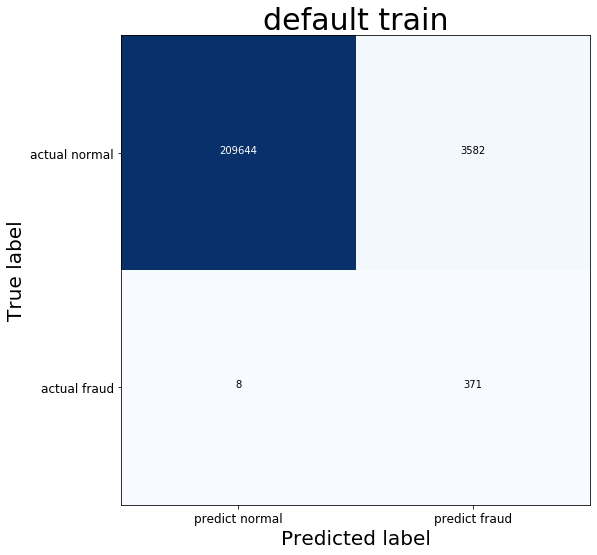

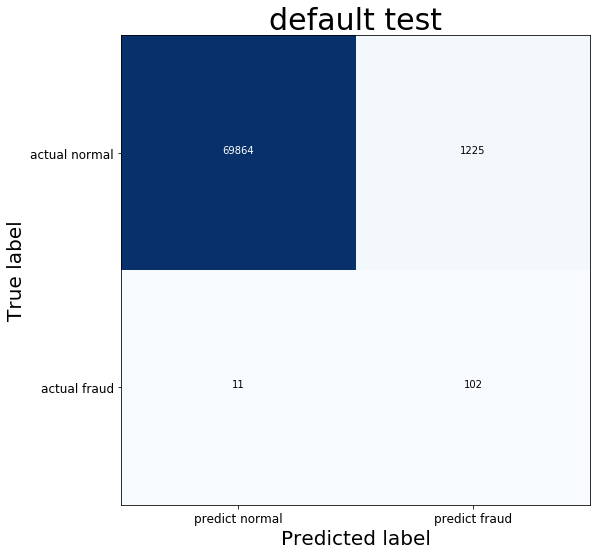

In [7]:
svc = SVC(random_state=42)
model = svc.fit(X_train_sm, y_train_sm.ravel())
model_vis(model,'default')

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
default stratify,1156,7,0.936675,0.938053,0.093569,0.083994,0.960274,0.960896


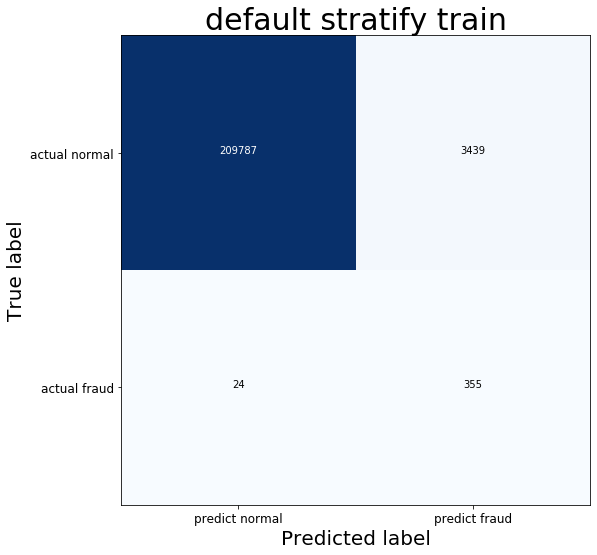

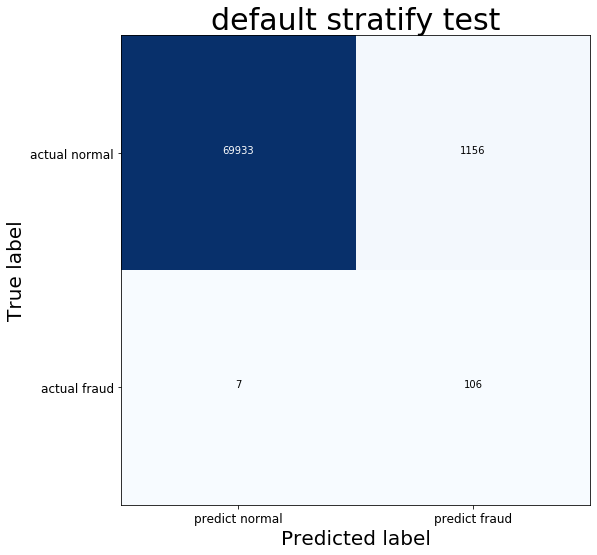

In [8]:
svc = SVC(random_state=42)
model = svc.fit(X_train_sm_sf, y_train_sm_sf.ravel())
model_vis(model,'default stratify')

### proceed with stratified data

# Param tuning

In [ ]:
# kernel:'rbf','sigmoid'(only when feature between 0,1),'linear','poly (default = 3)'
# C: pregularization penalty -- larger, more strict on error, low bias, high variance
# degree: only with kernel = 'poly'
# gamma: handle non-linear classification, small gamma low B high V

# Gridsearch 1

In [12]:
param_grid = {
    'C':[1,100,500,1000],
    'gamma':['scale','auto', 0.001]
}
gs1 = GridSearchCV(SVC(random_state=42), 
                   param_grid=param_grid, 
                   n_jobs=4, 
                   cv=5, 
                   verbose=5)
gs1.fit(X_train_sm_sf,y_train_sm_sf.ravel())

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 71.3min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed: 382.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=4,
             param_grid={'C': [1, 100, 500, 1000],
                         'gamma': ['scale', 'auto', 0.001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=5)

In [13]:
gs1.best_params_,gs1.best_score_

({'C': 1000, 'gamma': 'auto'}, 0.9997022081352522)

In [14]:
pd.DataFrame(gs1.cv_results_).sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,769.892249,186.073885,9.469071,1.104544,1000,auto,"{'C': 1000, 'gamma': 'auto'}",0.999613,0.999683,0.999789,0.999613,0.999812,0.999702,0.000085,1
7,785.953610,139.655951,9.957894,1.336184,500,auto,"{'C': 500, 'gamma': 'auto'}",0.999625,0.999648,0.999742,0.999637,0.999766,0.999683,0.000058,2
4,1181.576293,535.251708,12.111049,1.390139,100,auto,"{'C': 100, 'gamma': 'auto'}",0.999566,0.999613,0.999683,0.999648,0.999719,0.999646,0.000053,3
9,1637.337811,121.392440,28.941360,2.909620,1000,scale,"{'C': 1000, 'gamma': 'scale'}",0.998452,0.998710,0.998710,0.998581,0.998874,0.998666,0.000142,4
1,1148.618083,129.021697,48.562148,3.760572,1,auto,"{'C': 1, 'gamma': 'auto'}",0.998300,0.998265,0.998534,0.998546,0.998769,0.998483,0.000184,5
6,1150.515688,45.974854,32.714214,0.488320,500,scale,"{'C': 500, 'gamma': 'scale'}",0.998195,0.998183,0.998370,0.998288,0.998769,0.998361,0.000215,6
11,2148.454181,353.468085,51.712312,7.766630,1000,0.001,"{'C': 1000, 'gamma': 0.001}",0.996577,0.996084,0.996237,0.996483,0.997139,0.996504,0.000363,7
3,1304.504416,161.133039,77.405277,3.036415,100,scale,"{'C': 100, 'gamma': 'scale'}",0.996143,0.995650,0.996014,0.996307,0.996928,0.996208,0.000420,8
8,1972.273420,85.059701,80.281171,7.350802,500,0.001,"{'C': 500, 'gamma': 0.001}",0.995486,0.995064,0.995310,0.995416,0.996049,0.995465,0.000325,9
5,1338.331685,12.445272,104.734286,1.412715,100,0.001,"{'C': 100, 'gamma': 0.001}",0.991934,0.991570,0.991512,0.991969,0.992286,0.991854,0.000284,10


,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
gridsearch 1,7,15,0.886544,0.867257,0.915531,0.933333,0.943199,0.933579


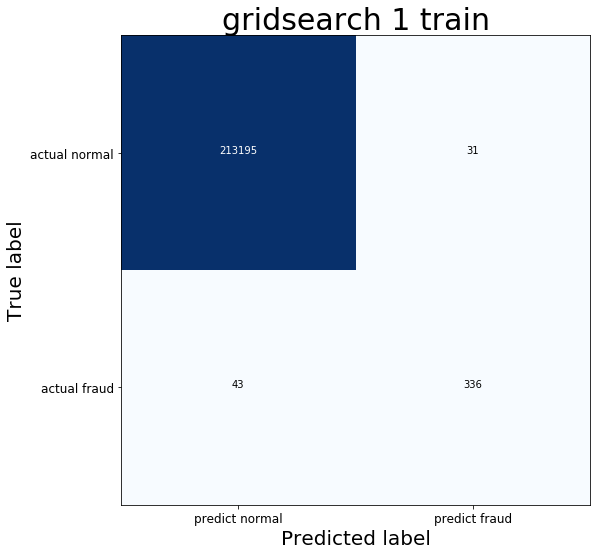

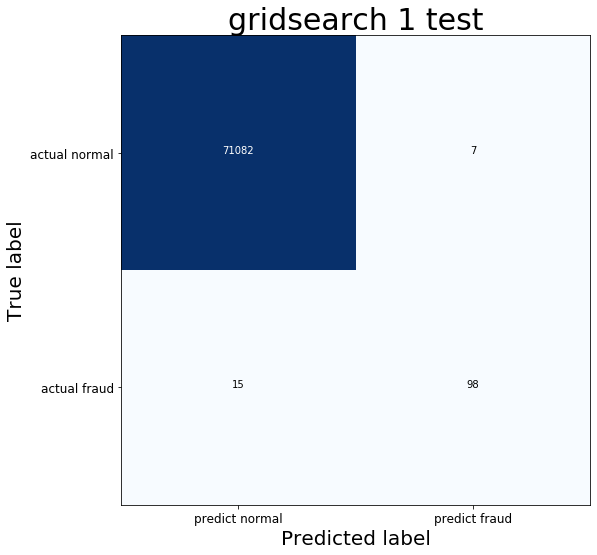

In [8]:
svc_grid = SVC(C = 1000, gamma = 'auto', random_state=42)
model = svc_grid.fit(X_train_sm_sf, y_train_sm_sf.ravel())
model_vis(model,'gridsearch 1')

# Gridsearch 2

In [9]:
param_grid = {
    'C' : range(800,1501,100)
}

gs2 = GridSearchCV(SVC(gamma = 'auto', random_state=42), 
                   param_grid= param_grid, 
                   cv = 5, 
                   n_jobs=4,
                   verbose=5)
gs2.fit(X_train_sm_sf,y_train_sm_sf.ravel())

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 45.5min
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed: 141.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto', kernel='rbf', max_iter=-1,
                           probability=False, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=4,
             param_grid={'C': range(800, 1501, 100)}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=5)

In [10]:
gs2.best_params_,gs2.best_score_

({'C': 1000}, 0.9997022081352522)

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
gridsearch edit,8,15,0.889182,0.867257,0.910811,0.924528,0.944514,0.933572


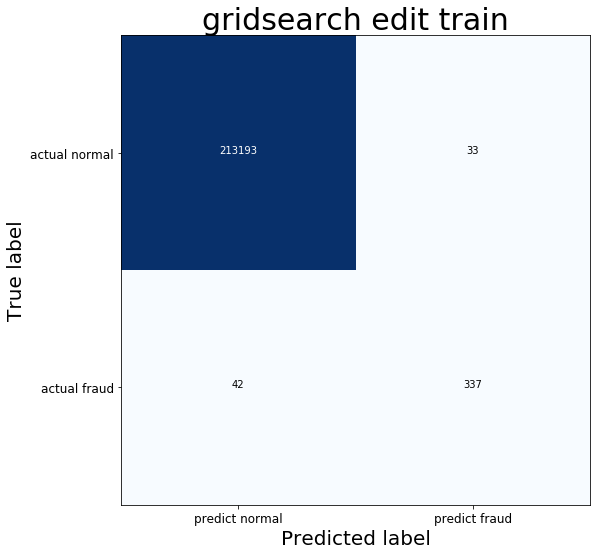

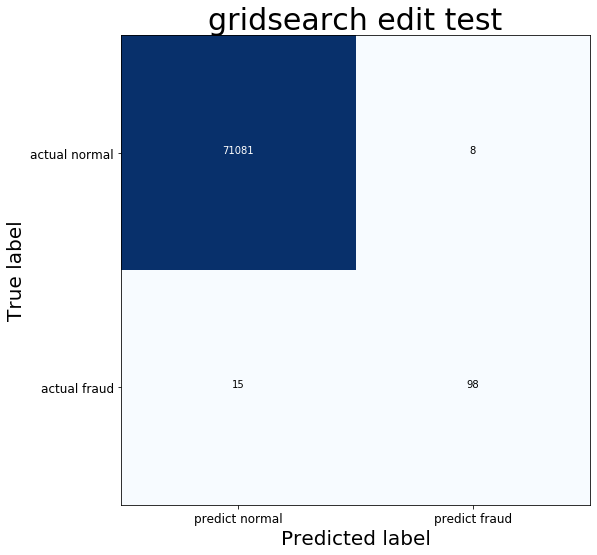

In [11]:
svc_grid = SVC(C = 800, gamma = 'auto', random_state=42)
model = svc_grid.fit(X_train_sm_sf, y_train_sm_sf.ravel())
model_vis(model,'gridsearch edit')

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
gridsearch C = 800,8,15,0.889182,0.867257,0.910811,0.924528,0.944514,0.933572


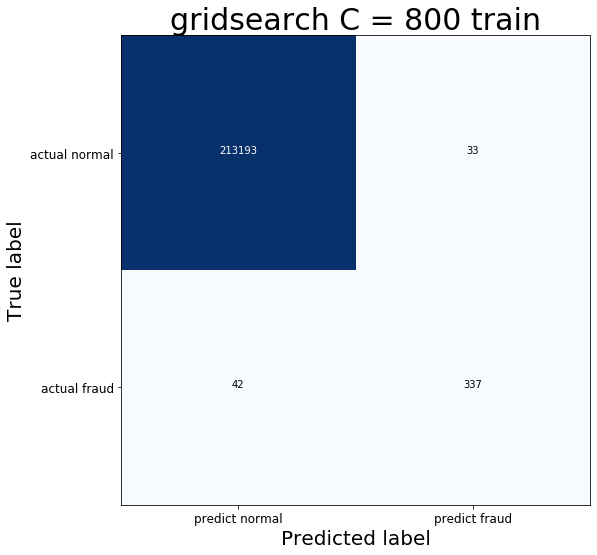

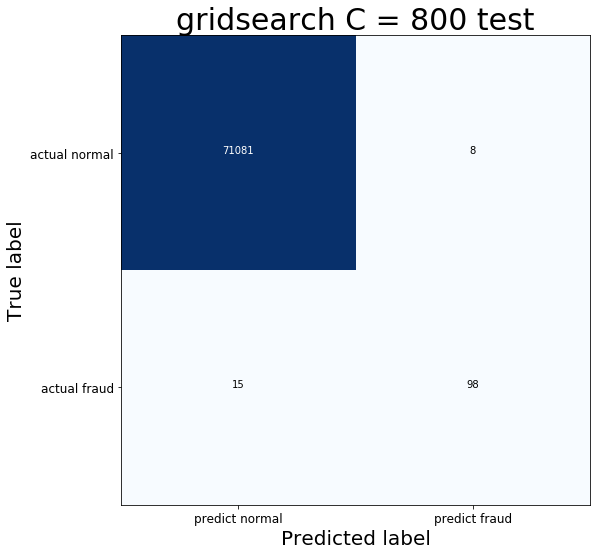

In [14]:
model_vis(model,'gridsearch C = 800')

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
gridsearch C =2000,7,15,0.883905,0.867257,0.910326,0.933333,0.941875,0.933579


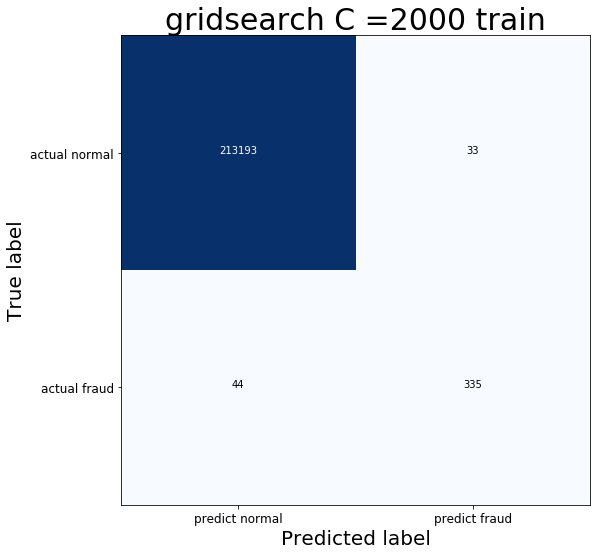

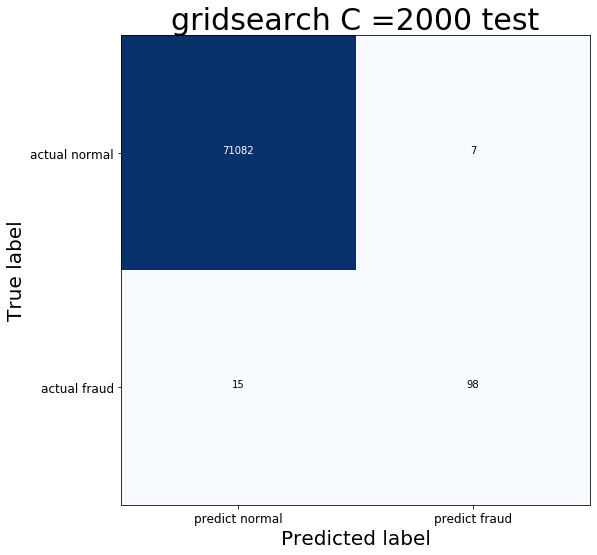

In [15]:
svc_grid = SVC(C = 2000, gamma = 'auto', random_state=42)
model = svc_grid.fit(X_train_sm_sf, y_train_sm_sf.ravel())
model_vis(model,'gridsearch C =2000')